In [1]:
import json
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from pydub import AudioSegment  
import matplotlib.pyplot as plt
root_dirs = {
    "Birdsong" : "/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/birdsong",
    "IEMOCAP"  : "/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/iemocap/iemocap/IEMOCAP",
    "MusicalInstruments" : "/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/magenta",
    "tut_urban" : "/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/utu/TUT-urban-acoustic-scenes-2018-development"
}

# BirdSong
```shell
python data_prep.py --root_dir "/speech/Databases/Birdsong/BirdSong/freefield1010" --no_workers 10 --prefix wav --suffix spec
```

In [2]:
root_dir = root_dirs["Birdsong"]

ff_txt = os.path.join(root_dir,"freefield1010/6035814")
df1 = pd.read_csv(ff_txt) 
df1['Path'] = df1.apply(lambda row: os.path.join( 'freefield1010','spec',str(row.itemid)+'.wav.npy'), axis = 1)
df1['PathL2'] = df1.apply(lambda row: os.path.join( 'freefield1010','specl2',str(row.itemid)+'.wav.npy'), axis = 1)
df1['AudioPath'] = df1.apply(lambda row: os.path.join( 'freefield1010','wav',str(row.itemid)+'.wav'), axis = 1)
df1.rename(columns = {'hasbird':'Label'}, inplace = True)
wab_txt = os.path.join(root_dir,"Warblr/6035817")
df2 = pd.read_csv(wab_txt) 
df2['Path'] = df2.apply(lambda row: os.path.join( 'Warblr','spec',str(row.itemid)+'.wav.npy'), axis = 1)
df2['PathL2'] = df2.apply(lambda row: os.path.join( 'Warblr','specl2',str(row.itemid)+'.wav.npy'), axis = 1)
df2['AudioPath'] = df2.apply(lambda row: os.path.join( 'Warblr','wav',str(row.itemid)+'.wav'), axis = 1)
df2.rename(columns = {'hasbird':'Label'}, inplace = True)
combined_df = df1.append(df2)

df1.to_csv(os.path.join(root_dir,"freefield1010_data.csv"),index=False)
df2.to_csv(os.path.join(root_dir,"Warblr_data.csv"),index=False)
combined_df.to_csv(os.path.join(root_dir,"combined_data.csv"),index=False)

In [5]:
dataset = combined_df
dataset["lenghts"] = None
for idx,row in dataset.iterrows() :
    wav_file = AudioSegment.from_file(file = os.path.join(root_dir,row['AudioPath']), format = "wav")
    dataset.loc[idx,"lenghts"] = len(wav_file)

FileNotFoundError: [Errno 2] No such file or directory: '/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/birdsong/freefield1010/wav/64486.wav'

# IEMOCAP

* total samples 7532
* 4 emotions toatl 4490
* train 3548
* test 942

In [2]:
root_dir = root_dirs["IEMOCAP"]

full_datacsv = pd.read_csv(os.path.join(root_dir,'iemocap_final.csv'))
full_datacsv['type'] = full_datacsv.apply(lambda row: "test" if str(row.wav_file).startswith('Ses05') else "train",
                                            axis=1)
full_datacsv['AudioPath'] = full_datacsv.apply(lambda row: os.path.join('wav',str(row.wav_file)+'.wav'), axis = 1)
full_datacsv['Path'] = full_datacsv.apply(lambda row: os.path.join('spec',str(row.wav_file)+'.wav.npy'), axis = 1)
full_datacsv['PathL2'] = full_datacsv.apply(lambda row: os.path.join('specl2',str(row.wav_file)+'.wav.npy'), axis = 1)
full_datacsv['Label'] = full_datacsv['emotion'] 
full_datacsv.drop(['index','start_time','end_time','val' ,'act' ,'dom' ,'emotion','wav_file'],axis=1,inplace=True)


In [5]:
len(full_datacsv)

4490

In [4]:
print(full_datacsv['Label'].unique())
index_names = full_datacsv[ full_datacsv['Label'].isin(['fru','exc','sur','oth','fea','dis']) ].index
full_datacsv.drop(index_names, inplace = True)
print(full_datacsv['Label'].unique())

['neu' 'fru' 'ang' 'sad' 'hap' 'exc' 'sur' 'oth' 'fea' 'dis']
['neu' 'ang' 'sad' 'hap']


In [9]:
grouped = full_datacsv.groupby(full_datacsv.type)

train = grouped.get_group("train").drop(['type'],axis=1)
test  = grouped.get_group("test").drop(['type'],axis=1)
print(len(train))
print(len(test))

train.to_csv(os.path.join(root_dir,'train_data.csv'),index=False)
test.to_csv(os.path.join(root_dir,'test_data.csv'),index=False)

3548
942


# Speech Commands V1

```shell
python data_prep.py --root_dir "/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/speechv1/train/" --no_workers 15 --prefix audio --suffix spec --file "labels.csv"
```


train samples : 56314
test samples : 6677

In [10]:
root_dir = "/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/speechv1/train"

test_labels = ["yes", "no", "up", "down","left", "right", "on", "off", "stop", "go" ] #10
core_labels = test_labels + ["zero","one","two","three","four","five","six","seven","eight","nine"] # 20
auxliary_labels = ["bird","dog","happy", "wow","bed","cat","house","marvin","sheila","tree"] #10
labels = core_labels+ auxliary_labels + ["silence"]

full_df = pd.DataFrame(columns = [ 'AudioPath', 'Label'])
audio_root_dir = os.path.join(root_dir , "audio")

for labe_id,label in tqdm(enumerate(labels)):
    audiofiles = os.listdir(os.path.join(audio_root_dir,label))
    for file in tqdm(audiofiles ,leave=False):
        file_path = os.path.join(label,file)
        full_df=full_df.append( {'AudioPath' : file_path, 'Label' : label} , ignore_index = True)
full_df.to_csv(os.path.join(root_dir,"labels.csv"),index=False)
full_df['Path'] = full_df.apply(lambda row: os.path.join('spec',str(row.AudioPath)+'.npy'), axis = 1)
full_df['PathL2'] = full_df.apply(lambda row: os.path.join('specl2',str(row.AudioPath)+'.npy'), axis = 1)


31it [01:37,  3.13s/it]


In [17]:
full_df

,AudioPath,Label,Path,PathL2
0,yes/c013fe4d_nohash_0.wav,yes,spec/yes/c013fe4d_nohash_0.wav.npy,specl2/yes/c013fe4d_nohash_0.wav.npy
1,yes/9db2bfe9_nohash_3.wav,yes,spec/yes/9db2bfe9_nohash_3.wav.npy,specl2/yes/9db2bfe9_nohash_3.wav.npy
2,yes/918a2473_nohash_2.wav,yes,spec/yes/918a2473_nohash_2.wav.npy,specl2/yes/918a2473_nohash_2.wav.npy
3,yes/146d97db_nohash_0.wav,yes,spec/yes/146d97db_nohash_0.wav.npy,specl2/yes/146d97db_nohash_0.wav.npy
4,yes/d0faf7e4_nohash_5.wav,yes,spec/yes/d0faf7e4_nohash_5.wav.npy,specl2/yes/d0faf7e4_nohash_5.wav.npy
...,...,...,...,...
70716,silence/exercise_bike95.wav,silence,spec/silence/exercise_bike95.wav.npy,specl2/silence/exercise_bike95.wav.npy
70717,silence/exercise_bike806.wav,silence,spec/silence/exercise_bike806.wav.npy,specl2/silence/exercise_bike806.wav.npy
70718,silence/pink_noise88.wav,silence,spec/silence/pink_noise88.wav.npy,specl2/silence/pink_noise88.wav.npy
70719,silence/running_tap54.wav,silence,spec/silence/running_tap54.wav.npy,specl2/silence/running_tap54.wav.npy


In [18]:
full_df.loc[~full_df.Label.isin(["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"]), "Label"]="unknown"

In [19]:
full_df.Label.unique()

array(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop',
       'go', 'unknown', 'silence'], dtype=object)

In [20]:
test_list = pd.read_csv(os.path.join(root_dir,"testing_list.txt"),header=None)[0].values
train_df = full_df[~full_df['AudioPath'].isin(test_list)]
test_df = full_df[full_df['AudioPath'].isin(test_list)]

train_df['AudioPath'] = train_df.apply(lambda row: os.path.join('audio',str(row.AudioPath)), axis = 1)
test_df['AudioPath'] = test_df.apply(lambda row: os.path.join('audio',str(row.AudioPath)), axis = 1)

/tmp/ipykernel_3557477/3534063450.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['AudioPath'] = train_df.apply(lambda row: os.path.join('audio',str(row.AudioPath)), axis = 1)
/tmp/ipykernel_3557477/3534063450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['AudioPath'] = test_df.apply(lambda row: os.path.join('audio',str(row.AudioPath)), axis = 1)


In [21]:
print(len(train_df))
print(len(test_df))
train_df.to_csv(os.path.join(root_dir,"train_data.csv"),index=False)
test_df.to_csv(os.path.join(root_dir,"test_data.csv"),index=False)

63886
6835


In [14]:
labels = pd.read_csv("/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/speech_v1/labels.csv")

In [21]:
list1 = full_df.AudioPath.values

In [22]:
list2 = labels.AudioPath.values

In [30]:
len(np.unique(list1))

62991

# TUT Urban 

* total samples : 8640
* fold1_train.txt 6122
* fold1_test.txt 2518  == fold1_evaluate.txt 2518 

In [41]:
root_dir = root_dirs["tut_urban"]
train_df = pd.read_csv(os.path.join(root_dir,"evaluation_setup","fold1_train.txt"),sep="\t",header=None)
train_df.columns = ["AudioPath","Label"]
test_df = pd.read_csv(os.path.join(root_dir,"evaluation_setup","fold1_evaluate.txt"),sep="\t",header=None)
test_df.columns = ["AudioPath","Label"]

train_df['Path'] = train_df.apply(lambda row: os.path.join('spec',str(row.AudioPath).split('/')[-1]+'.npy'), axis = 1)
train_df['PathL2'] = train_df.apply(lambda row: os.path.join('specl2',str(row.AudioPath).split('/')[-1]+'.npy'), axis = 1)

test_df['Path'] = test_df.apply(lambda row: os.path.join('spec',str(row.AudioPath).split('/')[-1]+'.npy'), axis = 1)
test_df['PathL2'] = test_df.apply(lambda row: os.path.join('specl2',str(row.AudioPath).split('/')[-1]+'.npy'), axis = 1)


In [42]:
train_df = train_df.reindex(columns=['Label','AudioPath','Path','PathL2'])
test_df = test_df.reindex(columns=['Label','AudioPath','Path','PathL2'])
train_df.to_csv(os.path.join(root_dir,'train_data.csv'),index=False)
test_df.to_csv(os.path.join(root_dir,'test_data.csv'),index=False)

# Libri100

* train samples  : 22830
* test samples : 5708
* 585 speakers

In [6]:
root_dir = "/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/libri100"
utt2spk_root = os.path.join(root_dir,"utt2spk")
utt2spk = dict()
with open(utt2spk_root) as f:
    for x in tqdm(f):
        key , value = x.split()
        if utt2spk.get(key, None)==None:
            utt2spk[key] = value #.add(1, 'Geeks')
        else:
            raise NotImplementedError    


28539it [00:00, 663363.23it/s]


In [7]:
train_txt = os.path.join(root_dir,"train_split.txt")
test_txt = os.path.join(root_dir,"test_split.txt")
train_ids = []
test_ids = []

print("no_of_speakers",len(set(utt2spk.values())))


with open(test_txt) as f:
    test_ids = f.read().splitlines() 


test_csv = pd.DataFrame(columns = ['AudioPath', 'Label'])
test_speakers=[]
for i in tqdm(test_ids):
    test_speakers.append(utt2spk[i])
    test_csv = test_csv.append({'AudioPath' : i+'.wav', 'Label' : utt2spk[i] }, 
                ignore_index = True)
print("no_of_speakers",len(set(test_speakers)))



with open(train_txt) as f:
    train_ids = f.read().splitlines() 


train_csv = pd.DataFrame(columns = ['AudioPath', 'Label'])
train_speakers=[]
for i in tqdm(train_ids):
    train_speakers.append(utt2spk[i])
    train_csv = train_csv.append({'AudioPath' : i+'.wav', 'Label' : utt2spk[i] }, 
                ignore_index = True)
print("no_of_speakers",len(set(train_speakers)))


no_of_speakers 585


100%|██████████| 5708/5708 [00:05<00:00, 956.16it/s]


no_of_speakers 585


100%|██████████| 22830/22830 [00:25<00:00, 899.97it/s]

no_of_speakers 585


In [9]:
len(test_csv)

5708

In [60]:
train_csv['Path'] = train_csv.apply(lambda row: os.path.join('spec',str(row.AudioPath)+'.npy'), axis = 1)
train_csv['PathL2'] = train_csv.apply(lambda row: os.path.join('specl2',str(row.AudioPath)+'.npy'), axis = 1)

test_csv['Path'] = test_csv.apply(lambda row: os.path.join('spec',str(row.AudioPath)+'.npy'), axis = 1)
test_csv['PathL2'] = test_csv.apply(lambda row: os.path.join('specl2',str(row.AudioPath)+'.npy'), axis = 1)

In [62]:
train_csv.to_csv(os.path.join(root_dir,"train_data.csv"),index=False)
test_csv.to_csv(os.path.join(root_dir,"test_data.csv"),index=False)

# Speech Commands v2

* labels :35
* total data samples 105829
* train : 94824
* test  : 11005

In [ ]:
test_labels = ["yes", "no", "up", "down","left", "right", "on", "off", "stop", "go","zero","one" ] #10
core_labels = test_labels + ["two","three","four","five","six","seven","eight","nine"] # 20
auxliary_labels = ["bird","dog","happy", "wow","bed","cat","house","marvin","sheila","tree"] #10

In [11]:
root_dir = "/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/speechv2/train"

labels = [ "bird","down","follow","go","learn", "silence",
"nine","on","seven","stop","two","wow","backward","cat","eight","forward","happy",
"left","no","one","sheila","three","up", "yes","bed","dog","five",
"four","house","marvin","off","right","six","tree","visual","zero"]

full_df = pd.DataFrame(columns = [ 'AudioPath', 'Label'])
audio_root_dir = os.path.join(root_dir , "audio")

for labe_id,label in tqdm(enumerate(labels)):
    audiofiles = os.listdir(os.path.join(audio_root_dir,label))
    for file in tqdm(audiofiles ,leave=False):
        file_path = os.path.join(label,file)
        full_df=full_df.append( {'AudioPath' : file_path, 'Label' : label} , ignore_index = True)
full_df.to_csv(os.path.join(root_dir,"labels.csv"),index=False)
full_df['Path'] = full_df.apply(lambda row: os.path.join('spec',str(row.AudioPath)+'.npy'), axis = 1)
full_df['PathL2'] = full_df.apply(lambda row: os.path.join('specl2',str(row.AudioPath)+'.npy'), axis = 1)


36it [03:10,  5.29s/it]


In [12]:
len(full_df)

111829

In [33]:
full_df.loc[~full_df.Label.isin(["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"]), "Label"]="unknown"

In [34]:
full_df.Label.unique()

array(['unknown', 'down', 'go', 'silence', 'on', 'stop', 'left', 'no',
       'up', 'yes', 'off', 'right'], dtype=object)

In [19]:
full_df.to_csv(os.path.join(root_dir,"labels.csv"),index=False)

In [35]:
test_list = pd.read_csv(os.path.join(root_dir,"testing_list.txt"),header=None)[0].values
train_df = full_df[~full_df['AudioPath'].isin(test_list)]
test_df = full_df[full_df['AudioPath'].isin(test_list)]

train_df['AudioPath'] = train_df.apply(lambda row: os.path.join('audio',str(row.AudioPath)), axis = 1)
test_df['AudioPath'] = test_df.apply(lambda row: os.path.join('audio',str(row.AudioPath)), axis = 1)

/tmp/ipykernel_231921/3534063450.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['AudioPath'] = train_df.apply(lambda row: os.path.join('audio',str(row.AudioPath)), axis = 1)
/tmp/ipykernel_231921/3534063450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['AudioPath'] = test_df.apply(lambda row: os.path.join('audio',str(row.AudioPath)), axis = 1)


In [36]:
train_df.to_csv(os.path.join(root_dir,"train_data.csv"),index=False)
test_df.to_csv(os.path.join(root_dir,"test_data.csv"),index=False)

In [37]:
train_df.Label.unique()

array(['unknown', 'down', 'go', 'silence', 'on', 'stop', 'left', 'no',
       'up', 'yes', 'off', 'right'], dtype=object)

# Chopping wave files for speechv2

In [3]:
full_df

,AudioPath,Label,Path,PathL2
0,bird/b91b718c_nohash_0.wav,bird,spec/bird/b91b718c_nohash_0.wav.npy,specl2/bird/b91b718c_nohash_0.wav.npy
1,bird/146d97db_nohash_0.wav,bird,spec/bird/146d97db_nohash_0.wav.npy,specl2/bird/146d97db_nohash_0.wav.npy
2,bird/46114b4e_nohash_0.wav,bird,spec/bird/46114b4e_nohash_0.wav.npy,specl2/bird/46114b4e_nohash_0.wav.npy
3,bird/ce9410da_nohash_0.wav,bird,spec/bird/ce9410da_nohash_0.wav.npy,specl2/bird/ce9410da_nohash_0.wav.npy
4,bird/8931f494_nohash_0.wav,bird,spec/bird/8931f494_nohash_0.wav.npy,specl2/bird/8931f494_nohash_0.wav.npy
...,...,...,...,...
105824,zero/179a61b7_nohash_3.wav,zero,spec/zero/179a61b7_nohash_3.wav.npy,specl2/zero/179a61b7_nohash_3.wav.npy
105825,zero/3a182c98_nohash_0.wav,zero,spec/zero/3a182c98_nohash_0.wav.npy,specl2/zero/3a182c98_nohash_0.wav.npy
105826,zero/619b5164_nohash_1.wav,zero,spec/zero/619b5164_nohash_1.wav.npy,specl2/zero/619b5164_nohash_1.wav.npy
105827,zero/54412eae_nohash_1.wav,zero,spec/zero/54412eae_nohash_1.wav.npy,specl2/zero/54412eae_nohash_1.wav.npy


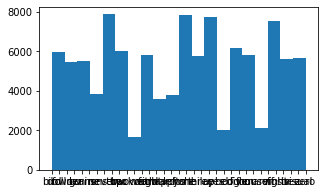

In [4]:
fig, ax = plt.subplots(figsize =(5,3))
ax.hist(full_df["Label"].values,bins=20)
plt.show()

In [5]:
# 6000 

wav_file = AudioSegment.from_file(file = os.path.join('/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/speechv2/train/audio/_background_noise_/dude_miaowing.wav'), format = "wav")

In [7]:
extract = wav_file[0:1000]

In [10]:
len(extract)
len(wav_file)

61806

In [17]:
def chop_audio(wav_file, L=1000, num=20):
    wav_file = AudioSegment.from_file(file = wav_file, format = "wav")
    for i in range(num):
        beg = np.random.randint(0, len(wav_file) - L)
        yield wav_file[beg: beg + L]

root_dir ="/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/speechv2/train/audio/"
list_sounds = ['doing_the_dishes.wav'] +  ['dude_miaowing.wav','exercise_bike.wav','pink_noise.wav','running_tap.wav','white_noise.wav']

for file in tqdm(list_sounds):
    for i,chop_file in tqdm(enumerate(chop_audio(os.path.join(root_dir,'_background_noise_',file),num=1000))):
        chop_file.export( os.path.join(root_dir,'silence',file.split('.')[0]+str(i)+'.wav'), format="wav")
        



1000it [00:01, 856.70it/s]
1000it [00:01, 874.52it/s]
1000it [00:01, 868.84it/s]
1000it [00:01, 890.27it/s]
1000it [00:01, 883.54it/s]
1000it [00:01, 913.77it/s]
100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


# Musical Instruments

In [7]:

root_dir = root_dirs["MusicalInstruments"] 

fi = open(os.path.join(root_dir,'nsynth-train','examples.json'))
train_json = json.load(fi)
train_csv=pd.DataFrame(columns=['AudioPath','Path','Label'])
for key in tqdm(train_json.keys()):
    train_csv=train_csv.append({'Path' : os.path.join('nsynth-train','spec',key+'.wav.npy'),
                                'Label' : train_json[key]['instrument_family'] ,
                                'AudioPath' : os.path.join('nsynth-train','audio',key+'.wav'),
                                },ignore_index=True)
fi.close()

fi = open(os.path.join(root_dir,'nsynth-valid','examples.json'))
valid_json = json.load(fi)

valid_csv=pd.DataFrame(columns=['AudioPath','Path','Label'])
for key in tqdm(valid_json.keys()):
    valid_csv=valid_csv.append({'Path' : os.path.join('nsynth-valid','spec',key+'.wav.npy'),
                                'Label' : valid_json[key]['instrument_family'],
                                'AudioPath' : os.path.join('nsynth-valid','audio',key+'.wav'), 
    },ignore_index=True)
fi.close()

fi = open(os.path.join(root_dir,'nsynth-test','examples.json'))
test_json = json.load(fi)

test_csv=pd.DataFrame(columns=['AudioPath','Path','Label'])
for key in tqdm(valid_json.keys()):
    test_csv=test_csv.append({'Path' : os.path.join('nsynth-test','spec',key+'.wav.npy'),
                                'Label' : valid_json[key]['instrument_family'],
                                'AudioPath' : os.path.join('nsynth-test','audio',key+'.wav'), 
                                },ignore_index=True)
fi.close()

# train_csv.to_csv(os.path.join(root_dir,'train_data.csv'),index=False)
# valid_csv.to_csv(os.path.join(root_dir,'valid_data.csv'),index=False)
# test_csv.to_csv(os.path.join(root_dir,'test_data.csv'),index=False)

 65%|██████▍   | 187043/289205 [18:43<10:13, 166.46it/s]


KeyboardInterrupt: 

In [5]:
valid_csv

,AudioPath,Path,Label
0,nsynth-valid/audio/keyboard_acoustic_004-060-0...,nsynth-valid/spec/keyboard_acoustic_004-060-02...,4
1,nsynth-valid/audio/bass_synthetic_033-050-100.wav,nsynth-valid/spec/bass_synthetic_033-050-100.w...,0
2,nsynth-valid/audio/bass_synthetic_009-052-050.wav,nsynth-valid/spec/bass_synthetic_009-052-050.w...,0
3,nsynth-valid/audio/keyboard_electronic_003-064...,nsynth-valid/spec/keyboard_electronic_003-064-...,4
4,nsynth-valid/audio/bass_synthetic_034-030-050.wav,nsynth-valid/spec/bass_synthetic_034-030-050.w...,0
...,...,...,...
25351,nsynth-test/audio/bass_electronic_025-051-127.wav,nsynth-test/spec/bass_electronic_025-051-127.w...,0
25352,nsynth-test/audio/flute_synthetic_000-080-025.wav,nsynth-test/spec/flute_synthetic_000-080-025.w...,2
25353,nsynth-test/audio/vocal_synthetic_003-073-025.wav,nsynth-test/spec/vocal_synthetic_003-073-025.w...,10
25354,nsynth-test/audio/bass_synthetic_134-036-100.wav,nsynth-test/spec/bass_synthetic_134-036-100.wa...,0


# Language ID

In [17]:
root_dir = "/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/lid"

train_df = pd.read_csv(os.path.join(root_dir,"train_path_voxforge.csv"))
train_df.columns = ['wav_file','Label']
train_df['AudioPath']= train_df.apply(lambda row: os.path.join('audio',str(row.wav_file)), axis = 1)
train_df['Path']= train_df.apply(lambda row: os.path.join('spec',str(row.wav_file)+'.npy'), axis = 1)
train_df['PathL2']= train_df.apply(lambda row: os.path.join('specl2',str(row.wav_file)+'.npy'), axis = 1)
train_df.drop(['wav_file'],axis=1,inplace=True)


test_df = pd.read_csv(os.path.join(root_dir,"valid_path_voxforge.csv"))
test_df.columns = ['wav_file','Label']
test_df['AudioPath']= test_df.apply(lambda row: os.path.join('audio',str(row.wav_file)), axis = 1)
test_df['Path']= test_df.apply(lambda row: os.path.join('spec',str(row.wav_file)+'.npy'), axis = 1)
test_df['PathL2']= test_df.apply(lambda row: os.path.join('specl2',str(row.wav_file)+'.npy'), axis = 1)
test_df.drop(['wav_file'],axis=1,inplace=True)

In [18]:
test_df.Label.unique()

array(['french', 'spanish', 'german', 'russian', 'english', 'italian'],
      dtype=object)

In [19]:
train_df.to_csv("/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/lid/train_data.csv",index=False)
test_df.to_csv("/nlsasfs/home/nltm-pilot/sandeshk/icassp/data/lid/test_data.csv",index=False)